# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
import os
import shutil
import utils

ctx = mx.gpu(0)

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
        
arrayds_dir = '/home/hui/dataset/CIFAR10/arraydataset/'

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')

def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0, pathes=None, arrayds=False):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    if pathes is None:
        train_ds = gluon.data.vision.datasets.CIFAR100(train=True, transform=transform_train)
    else:
        if not arrayds:
            train_ds = MultiFolderDataset(pathes, transform=transform_train)
        else:
            train_ds = MyArrayDataset(load_all_data_label(pathes), transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR100(train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [4]:
from cifar10_utils import show_images
%matplotlib inline

def SGD(data, lr):
    data[:] = data - data.grad * lr
    
def inv_normalize(data, clip=True):
    mean=np.array([0.4914, 0.4822, 0.4465])
    std=np.array([0.2023, 0.1994, 0.2010])
    images = data.transpose((0, 2, 3, 1)).asnumpy()
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images
    
def show_data(data, clip=True):
    images = inv_normalize(data, clip)
    show_images(images)
    
def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=True, combine_batch=False):
    for iters in range(1, max_iters+1):
        with autograd.record():
            data.attach_grad()
            output = net(data.as_in_context(ctx))
            loss = -loss_f(output, label.as_in_context(ctx))
        loss.backward()
        
        if iter_log and iters % 50 == 0:
            show_data(data[:10], clip)
            print data[0, 0, :2, :10]
            print data.grad[0, 0, :2, :10]
        if iter_log and iters % 5 == 0:
            print 'iter:', iters, 'loss:', nd.mean(loss).asscalar()
        
        SGD(data, lr)
    return data, (nd.mean(loss).asscalar(),)

In [5]:
def get_soft_label(y, num_class, soft_label_th):
    y = y.reshape((-1,))
    ny = (y.one_hot(num_class) + soft_label_th / num_class)
    y = y.asnumpy()
    ny[range(y.shape[0]), y.astype('int32')] -= soft_label_th
    return nd.array(ny)

# 4. define train function

In [7]:
train_data, valid_data = data_loader(32, transform_train_DA1, num_workers=4, 
                                     pathes=[arrayds_dir + 'backgrad_resnet18_me_200e_iter10.ndarray']
                                     , arrayds=True)

In [9]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_200e", ctx=ctx)

print "backgrad image acc for origin net: ", utils.evaluate_accuracy(train_data, net, ctx)

backgrad image acc for origin net:  0.444177863084


In [10]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_200e_backgrad_iter10", ctx=ctx)

print "backgrad image acc for net trained with backgrad_iter10: ", utils.evaluate_accuracy(train_data, net, ctx)

backgrad image acc for net trained with backgrad_iter10:  1.0


In [11]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_200e_backgrad", ctx=ctx) # iter15

print "backgrad image acc for net trained with backgrad_iter15: ", utils.evaluate_accuracy(train_data, net, ctx)

backgrad image acc for net trained with backgrad_iter15:  0.999580134357


In [9]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01_addbatch", ctx=ctx)
print "backgrad image acc for net trained online: ", utils.evaluate_accuracy(train_data, net, ctx)

backgrad image acc for net trained online:  0.981825815739


In [15]:
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
loss, num = 0., 0
for data, label in train_data:
    output = net(data.as_in_context(ctx))
    loss += nd.sum(loss_f(output, label.as_in_context(ctx))).asscalar()
    num += data.shape[0]
print "backgrad image loss for net trained online: ", loss / num

backgrad image loss for net trained online:  0.123514819562


In [13]:
train_data, valid_data = data_loader(32, transform_train_DA1, num_workers=4, 
                                     pathes=[arrayds_dir + 'origin.ndarray']
                                     , arrayds=True)

In [15]:
for data, label in train_data:
    break

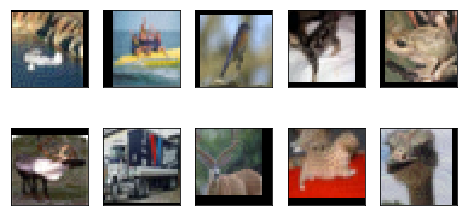

iter: 5 loss: -0.107876
iter: 10 loss: -0.177177
-0.177177


In [22]:
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
show_data(data[:10], False)
backgrad_data, (loss,) = generate_backgrad_data(net, data.copy(), label, max_iters=10, lr=0.1, iter_log=True, clip=False)
print loss

In [23]:
output = net(backgrad_data.as_in_context(ctx))
result = output.argmax(axis=1)
print nd.mean(result == label.reshape(result.shape).as_in_context(ctx))


[ 0.9375]
<NDArray 1 @gpu(0)>
